# Play with simulating multi-echo data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')


def predict_bold_signal(echo_times, s0, t2s):
    """Predict multi-echo signal according to monoexponential decay model.

    Parameters
    ----------
    echo_times : numpy.ndarray of shape (tes,)
        Echo times for which to predict data, in milliseconds.
    s0 : numpy.ndarray of shape (time,)
        S0 time series.
    t2s : numpy.ndarray of shape (time,)
        T2* time series.

    Returns
    -------
    data : numpy.ndarray of shape (tes, time)
        Predicted BOLD signal from each of the echo times.

    Notes
    -----
    This is meant to be a sort of inverse to the code used in tedana.decay.fit_decay
    """
    if not isinstance(t2s, np.ndarray):
        t2s = np.array([t2s])

    if not isinstance(s0, np.ndarray):
        s0 = np.array([s0])

    neg_tes = (-1 * echo_times)[None, :]
    r2s = (1 / t2s)[:, None]
    intercept = np.log(s0)[:, None]
    log_data = np.dot(r2s, neg_tes) + intercept
    # Removed -1 from outside exp because it messes up dt_sig2
    data = np.exp(log_data).T
    return data


def combine_t2s(data, tes, ft2s):
    """Combine data across echoes using weighted averaging according to estimates of T2*.

    The T2* estimates may be voxel- or voxel- and volume-wise.

    This method was proposed in :footcite:t:`posse1999enhancement`.

    Parameters
    ----------
    data : (M x E x T) array_like
        Masked data.
    tes : (1 x E) array_like
        Echo times in milliseconds.
    ft2s : (M [x T] X 1) array_like
        Either voxel-wise or voxel- and volume-wise estimates of T2*.

    Returns
    -------
    combined : (M x T) :obj:`numpy.ndarray`
        Data combined across echoes according to T2* estimates.
    """
    n_vols = data.shape[-1]
    alpha = tes * np.exp(-tes / ft2s)
    if alpha.ndim == 2:
        # Voxel-wise T2 estimates
        alpha = np.tile(alpha[:, :, np.newaxis], (1, 1, n_vols))
    elif alpha.ndim == 3:
        # Voxel- and volume-wise T2 estimates
        # alpha is currently (S, T, E) but should be (S, E, T) like mdata
        alpha = np.swapaxes(alpha, 1, 2)

        # If all values across echos are 0, set to 1 to avoid
        # divide-by-zero errors
        ax0_idx, ax2_idx = np.where(np.all(alpha == 0, axis=1))
        alpha[ax0_idx, :, ax2_idx] = 1.0
    combined = np.average(data, axis=1, weights=alpha)
    return combined

In [2]:
pal = sns.color_palette("cubehelix", 8)

# Simulate data
N_VOLS = 200

SCALING_FRACTION = 0.1  # used to scale standard deviation
MEAN_T2S = 35
MEAN_S0 = 10000

# echo_times = np.array([15, 30, 45, 60, 75])
echo_times = np.array([14.2, 38.93, 63.66, 88.39, 113.12])

# simulate the T2*/S0 time series
# The original time series will be a random time series from a normal distribution
rng = np.random.default_rng(0)
mean = [0, 0]
cov = [[1, 0], [0, 1]]
X = rng.multivariate_normal(mean, cov, size=N_VOLS)
print(X.shape)
print(np.corrcoef(X.T))
X = stats.zscore(X, axis=0)
t2s_ts = X[:, 0]
s0_ts = X[:, 1]

t2s_ts = (t2s_ts * 5) + MEAN_T2S
s0_ts = (s0_ts * MEAN_S0 * SCALING_FRACTION) + MEAN_S0

(200, 2)
[[1.         0.05355052]
 [0.05355052 1.        ]]


## Plot unscaled T2* and S0 time series

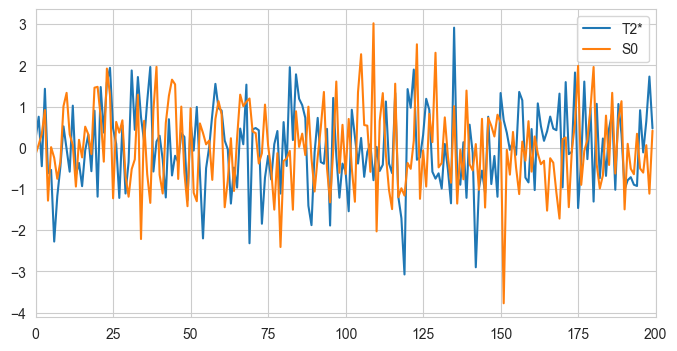

In [3]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X, label=['T2*', 'S0'])
ax.set_xlim(0, N_VOLS)
ax.legend()

## Plot scaled T2* time series

35.0
5.0


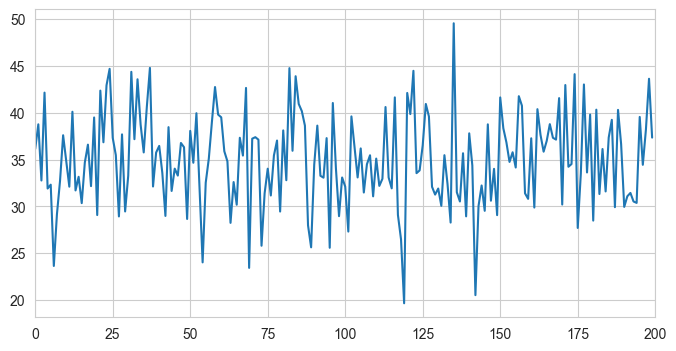

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t2s_ts)
ax.set_xlim(0, N_VOLS)
print(np.mean(t2s_ts))
print(np.std(t2s_ts))

## Simulate multi-echo data from T2* and S0 fluctuations

In [5]:
predicted_bold = predict_bold_signal(echo_times, s0_ts, t2s_ts)

(0.0, 200.0)

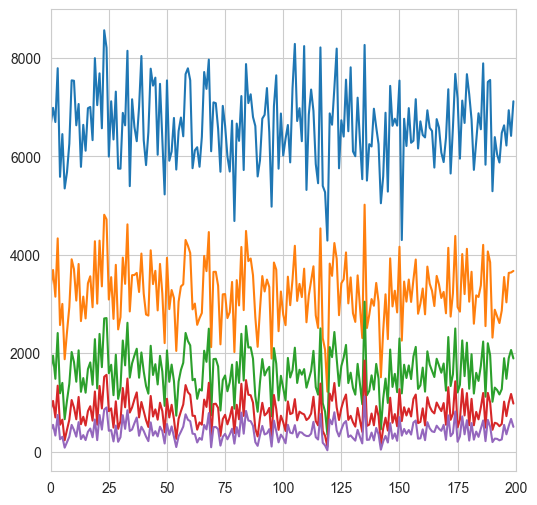

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(predicted_bold.T)
ax.set_xlim(0, N_VOLS)

## Look at S0 and T2* weighting in optimally combined data

We'll optimally combine the simulated data across echoes assuming a range of T2* values,
then z-score the optimally-combined time series, and finally record the parameter estimates from regressing the optimally-combined data on the z-scores S0 and T2* time series.
The result should indicate the amount of S0 vs. T2* weighting when optimally combining data with an actual mean T2* of 35 ms but assuming a T2* of something else.

In [7]:
# Optimally combine the data across echoes assuming a given T2*
ft2s = np.arange(1, 501, 0.1)
pes = np.zeros((ft2s.size, 2))
scale_pes = np.zeros((ft2s.size, 2))
cnr = np.zeros(ft2s.size)
for i_t2s, t2s in enumerate(ft2s):
    optcom = np.squeeze(combine_t2s(predicted_bold[None, ...], echo_times, t2s))
    optcom_z = stats.zscore(optcom)
    t2s_pes = np.linalg.lstsq(X, optcom_z)[0]
    t2s_scale_pes = np.linalg.lstsq(X, optcom)[0]
    pes[i_t2s, :] = t2s_pes
    scale_pes[i_t2s, :] = t2s_scale_pes

    # Measure temporal contrast-to-noise ratio (I think)
    pred_t2s_ts = (X[:, 0] * t2s_pes[0])
    cnr_t2s = t2s_pes[0] / np.std(optcom_z - pred_t2s_ts)
    cnr_t2s = np.std(pred_t2s_ts) / np.std(optcom_z)
    cnr[i_t2s] = cnr_t2s

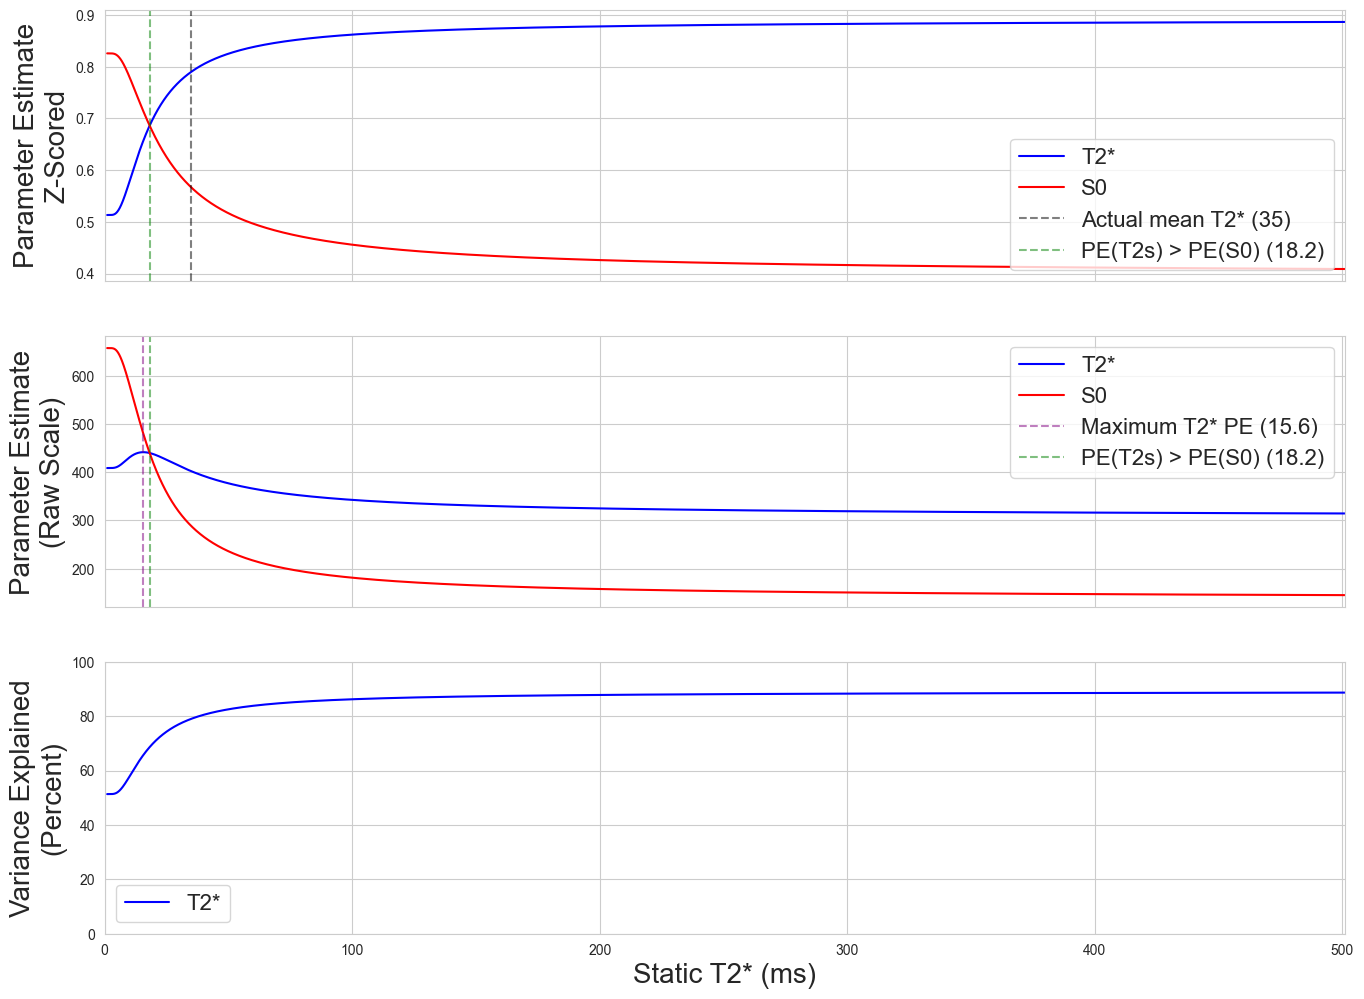

In [8]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3, sharex=True)

# Z-scored optcom data
axes[0].plot(ft2s, pes[:, 0], color='blue', label='T2*')
axes[0].plot(ft2s, pes[:, 1], color='red', label='S0')
axes[-1].set_xlabel('Static T2* (ms)', fontsize=20)
axes[0].axvline(
    MEAN_T2S,
    color='black',
    linestyle='--',
    alpha=0.5,
    label=f'Actual mean T2* ({MEAN_T2S})',
)
better_t2s_idx = np.where(scale_pes[:, 0] > scale_pes[:, 1])[0]
if better_t2s_idx.size:
    better_t2s_idx = better_t2s_idx[0]
    better_t2s = ft2s[better_t2s_idx]
else:
    better_t2s_idx = np.nan
    better_t2s = np.nan

axes[0].axvline(
    better_t2s,
    linestyle='--',
    color='green',
    alpha=0.5,
    label=f'PE(T2s) > PE(S0) ({np.round(better_t2s, 1)})',
)
axes[0].set_xlim(0, np.max(ft2s))
axes[0].legend(fontsize=16, loc='lower right')
axes[0].set_ylabel('Parameter Estimate\nZ-Scored', fontsize=20)

# Original scale
axes[1].plot(ft2s, scale_pes[:, 0], color='blue', label='T2*')
axes[1].plot(ft2s, scale_pes[:, 1], color='red', label='S0')
best_scaled_t2s_idx = np.argmax(scale_pes[:, 0])
best_scaled_t2s = ft2s[best_scaled_t2s_idx]
axes[1].axvline(
    best_scaled_t2s,
    linestyle='--',
    color='purple',
    alpha=0.5,
    label=f'Maximum T2* PE ({np.round(best_scaled_t2s, 1)})',
)

axes[1].axvline(
    better_t2s,
    linestyle='--',
    color='green',
    alpha=0.5,
    label=f'PE(T2s) > PE(S0) ({np.round(better_t2s, 1)})',
)
axes[1].legend(fontsize=16)
axes[1].set_ylabel('Parameter Estimate\n(Raw Scale)', fontsize=20)

axes[2].plot(ft2s, cnr * 100, color='blue', label='T2*')
axes[2].set_ylabel("Variance Explained\n(Percent)", fontsize=20)
axes[2].set_ylim(0, 100)
axes[2].legend(fontsize=16)

## Determine echo-wise weighting from optimal combination step for each static T2*

In [9]:
tes = echo_times[:, None]
ft2s_ = ft2s[None, :]

alpha = tes * np.exp(-tes / ft2s_)
alpha = alpha / np.sum(alpha, axis=0)
echo_names = [f'Echo {i + 1}' for i in range(len(echo_times))]
alpha_df = pd.DataFrame(index=ft2s, columns=echo_names, data=alpha.T)

# We want ascending echoes to have the cumulative sum.
alpha_df = alpha_df.cumsum(axis=1)
alpha_df['T2*'] = alpha_df.index
alpha_df.head()

,Echo 1,Echo 2,Echo 3,Echo 4,Echo 5,T2*
1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.1,1.0,1.0,1.0,1.0,1.0,1.1
1.2,1.0,1.0,1.0,1.0,1.0,1.2
1.3,1.0,1.0,1.0,1.0,1.0,1.3
1.4,1.0,1.0,1.0,1.0,1.0,1.4


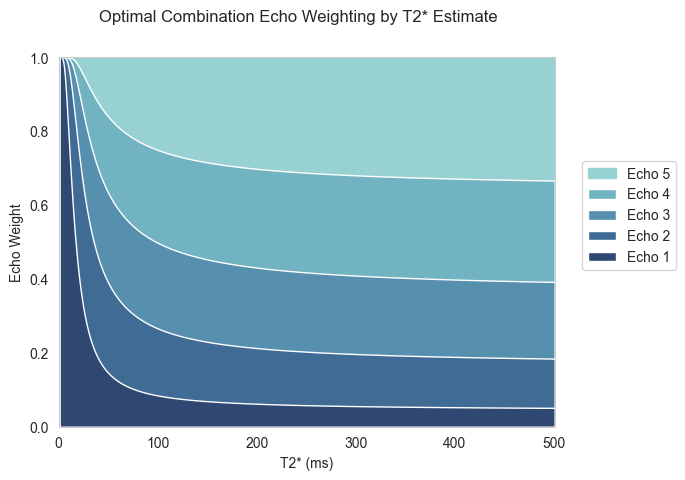

In [10]:
fig, ax = plt.subplots()
echo_cols = sorted([c for c in alpha_df.columns.tolist() if c.startswith('Echo ')], reverse=True)
palette = sns.color_palette('ch:rot=-.25,hue=1,light=.75')
for i_col, col in enumerate(echo_cols):
    y = alpha_df[col]
    x = alpha_df['T2*']
    kwargs = {}
    if i_col != 0:
        kwargs = {'edgecolor': 'white'}
    ax.fill_between(x, y, color=palette[i_col], label=col, **kwargs)

ax.set_ylim(0, 1)
ax.set_xlim(0, np.max(ft2s))
ax.set_xlabel('T2* (ms)')
ax.set_ylabel('Echo Weight')
fig.suptitle('Optimal Combination Echo Weighting by T2* Estimate')
fig.legend(loc='outside center right', bbox_to_anchor=(0., 0.5, 1.1, 0.1))